In [2]:
"""
Created By    : Lynnlee Rosolino
Creation Date : 25 October 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
A first pass analysis was created using a Cressman weight function,
and then a second and third pass were created using a bilinear 
interpolation and the Cressman weight function. The differences between
the analyses was also calculated and plotted along with calculating the
RMS difference.

"""
__author__    = "Lynnlee Rosolino"
__contact__   = "lynnlee.rosolino@und.edu"

In [3]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
!pip install pandas
import pandas as pd                #pandas to spite jared

In [4]:
### Read in observations ###
data=pd.read_csv("RAOBs_201903131200.txt", delimiter=",",names=["station","lat","lon","500mbheight","500mbwinddir","500mbwindspeed"])
data[data.columns[1:5]]=data[data.columns[1:5]].astype(float) #numbers
#convert lat&lon to radians and add to data
data["lat_rad"]=data['lat']*(np.pi/180)
data["lon_rad"]=data['lon']*(np.pi/180)

#constants
mapproj=1/(15e6)
rho=6371*1e5
lambda0=-115
phi0=60*(np.pi/180)
f0=data["500mbheight"].values #heights in roi
f0=np.array(f0)

In [5]:
### Create function for Cressman Analysis ###
def cressman(dik,R):
    if(dik<=R):
        w=((R**2)-(dik**2))/((R**2)+(dik**2))
    elif(dik>R):
        w=0
    else:
        print("WRONG!")
    return w

In [6]:
### Create function for bilinear interpolation ###
def bilinear(x,y,ROI):
    rel_x=x-np.floor(x)
    rel_y=y-np.floor(y)
    
    z1=analmat[int(np.floor(y)),int(np.floor(x)),ROI]
    z2=analmat[int(np.ceil(y)),int(np.floor(x)),ROI]
    z3=analmat[int(np.ceil(y)),int(np.ceil(x)),ROI]
    z4=analmat[int(np.floor(y)),int(np.ceil(x)),ROI]
    
    #delta x and delta y are both one so I'm going to ignore the first term
    P=((rel_x-1)*(rel_y-1)*z1)-((rel_x-0)*(rel_y-1)*z2)+((rel_x-0)*(rel_y-0)*z3)-((rel_x-1)*(rel_y-0)*z4)
    return P

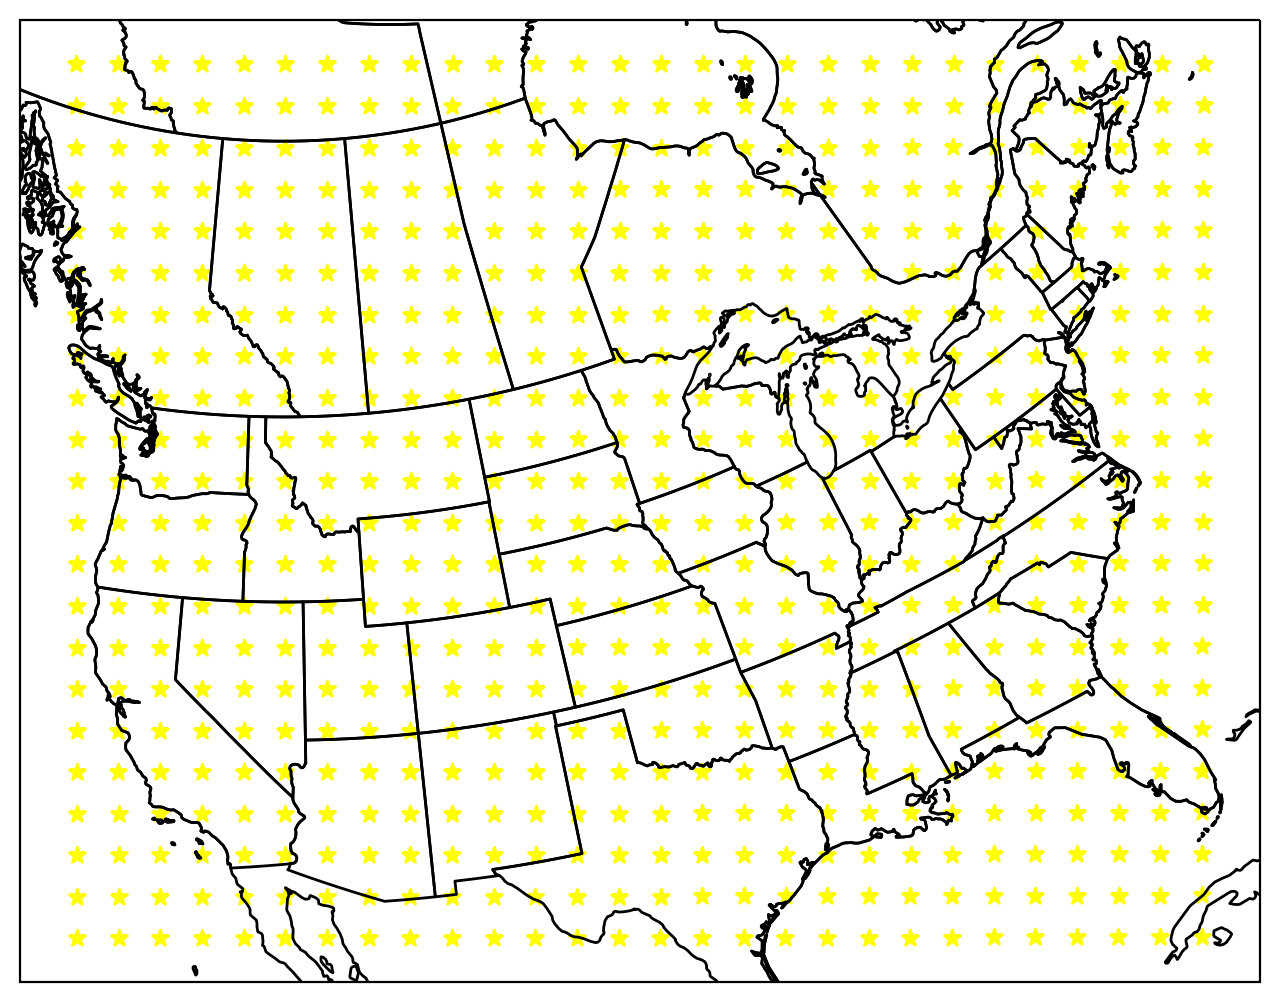

In [7]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#find grid points, set up x-y grid
x_step=18.9+np.arange(22)*1.27
y_step=-6.3+np.arange(28)*1.27
x,y =np.meshgrid(x_step,y_step)

#transform equations into lat/lon
xlon=np.arctan(y/x)*(180/np.pi)+lambda0
ylat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/mapproj)**2+(y/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="*",color="yellow")

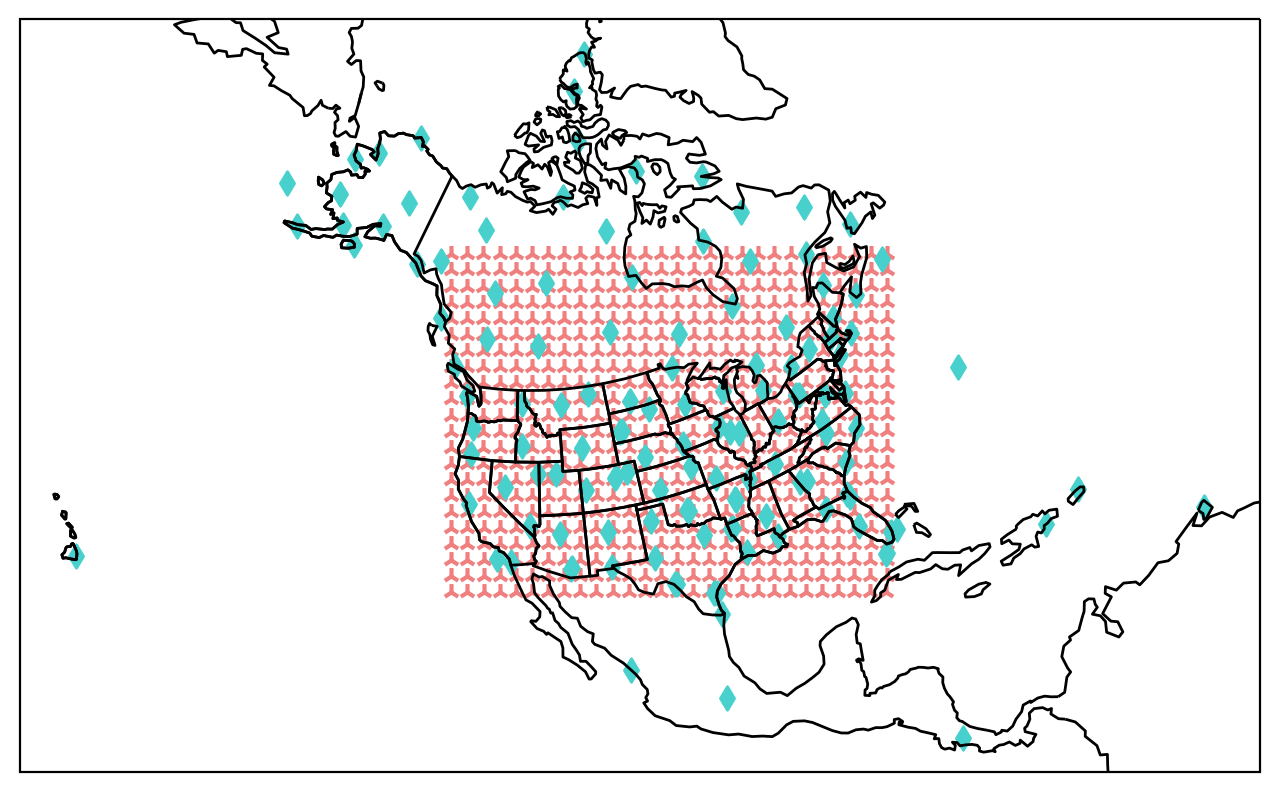

In [8]:
### convert obs lat/long to x,y ###
#assign vars
phi=data["lat_rad"]
lambdy=data["lon_rad"]

#solve for image scale factor
sigma=(1+np.sin(phi0))/(1+np.sin(phi))

#solve radius of lat circle
r=rho*sigma*np.cos(phi)

#deviation of lon from standard
dev=lambdy-(lambda0*np.pi/180)
xdev=r*np.cos(dev)*mapproj
ydev=r*np.sin(dev)*mapproj

#convert to array
xdev=np.array(xdev)
ydev=np.array(ydev)

#convert back to lat/lon
data_lon=np.arctan(ydev/xdev)*(180/np.pi)+lambda0
data_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((xdev/mapproj)**2+(ydev/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="2",color="lightcoral")
ax1.scatter(data_lon,data_lat,transform=ccrs.PlateCarree(),marker="d",color="mediumturquoise")

In [9]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin

#calculate dmin (average distance between obs)
dist=[]

for i in range(135):
    Rr=((xdev[i]-xdev)**2+(ydev[i]-ydev)**2)**0.5
    Rr.sort()
    dist.append(Rr[1])
dmin=np.mean(dist)

#calculate radii of influence
R1=4*dmin
R2=2.5*dmin
R3=1.5*dmin

yrow=22
xcol=28

#roi array
roiarray=np.array([R1,R2,R3])
#make empty obs and analysis matrices
analmat=np.zeros((xcol,yrow,len(roiarray)))

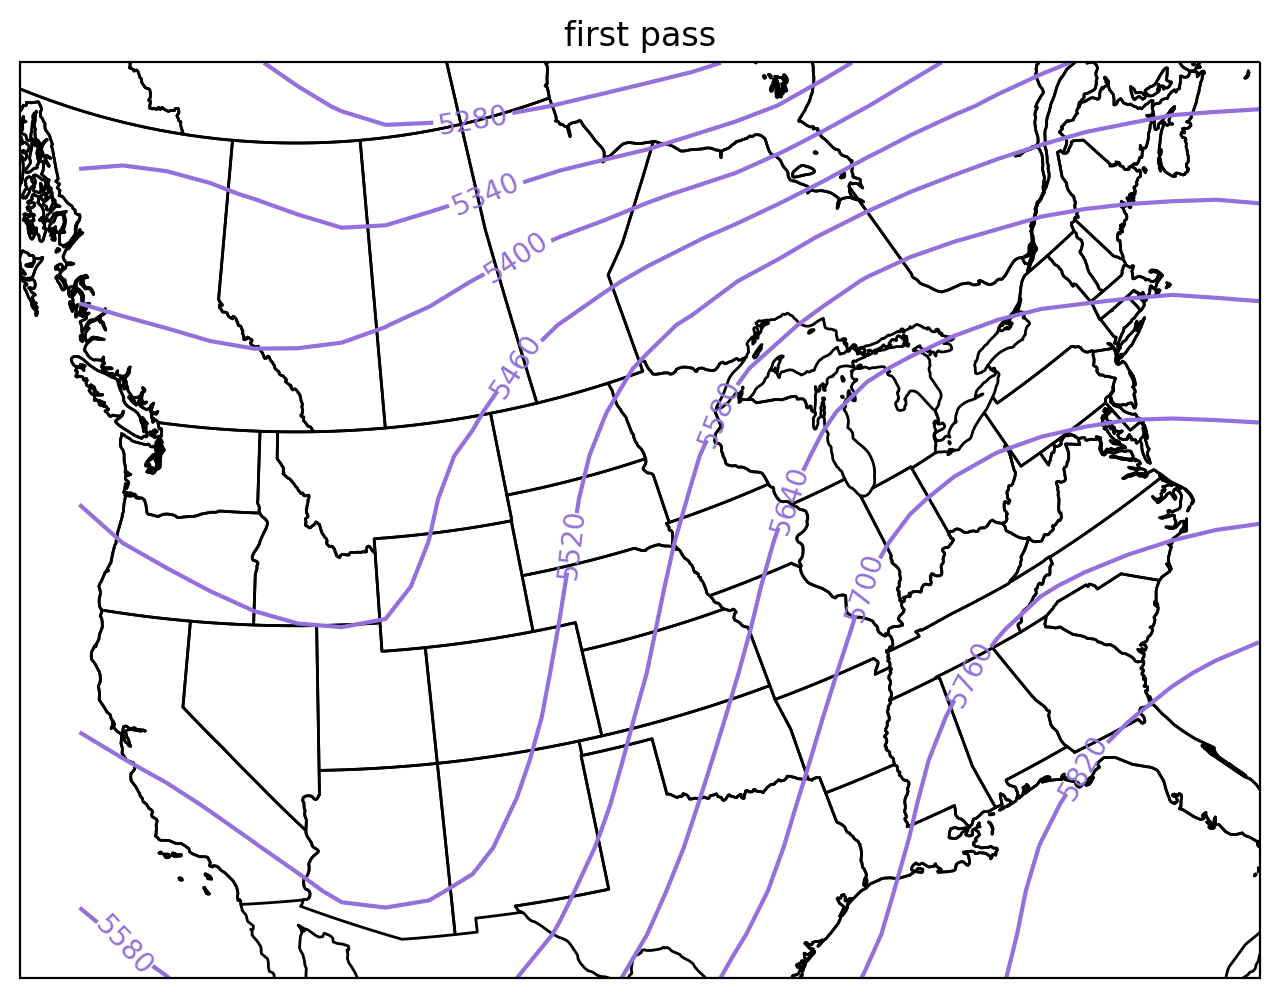

In [10]:
#feelin loopy after writin this loop
for j in range(len(x)):
    for k in range(len(x[0])):
        xs=x[j,k]-xdev   #grid point - loc of obs
        ys=y[j,k]-ydev   #grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        #make sure obs are in roi
        roi_index=np.where(radius<=R1)[0]
        #empty matrix for weights
        weights=np.zeros(len(xdev))
        for i in roi_index:
            w=cressman(radius[i],R1)
            weights[i]=w
        analmat[j,k,0]=np.sum(weights*f0)/np.sum(weights)
         
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,0],colors='mediumpurple',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("first pass")
plt.savefig('firstpass.png')
#plt.show()

In [28]:
#calculate relative x and y for bilinear
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P1=np.zeros(len(xdev))
#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear(ob_relx[i],ob_rely[i],0) #zero uses analysis value from first pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=R1)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                cress_a=cressman(radius[j,k],R1)
                weights_a[j,k]=cress_a
        p=np.sum(weights_a*analmat[:,:,0])/np.sum(weights_a)
    P1[i]=p

5310.023285440846
5283.77561646846
nan
5307.405837478486
5330.569999439688
5515.6624069904965
nan
5394.801892908817
5249.545450678166
5275.536464295044
5411.5959970277145
5315.56549791323
5476.82005804884
5514.5126620082465
5321.934976823972
5309.84763935921
5320.466032527395
5369.574155524093
5299.478304630536
5720.054982284982


C:\Users\lynnl\AppData\Local\Temp\ipykernel_37240\245028735.py:20: RuntimeWarning: invalid value encountered in double_scalars
  p=np.sum(weights_a*analmat[:,:,0])/np.sum(weights_a)


5300.376455487565
nan
5704.585127638608
5314.933833500192
nan
nan
nan
5743.366522517487
5832.689692707927
5832.324941132855
5604.5487535173825
5709.132613203911
5838.70603976793
nan
5299.478304630536
nan
nan
nan
5672.890410428047
5338.348802290196
5335.762915452313


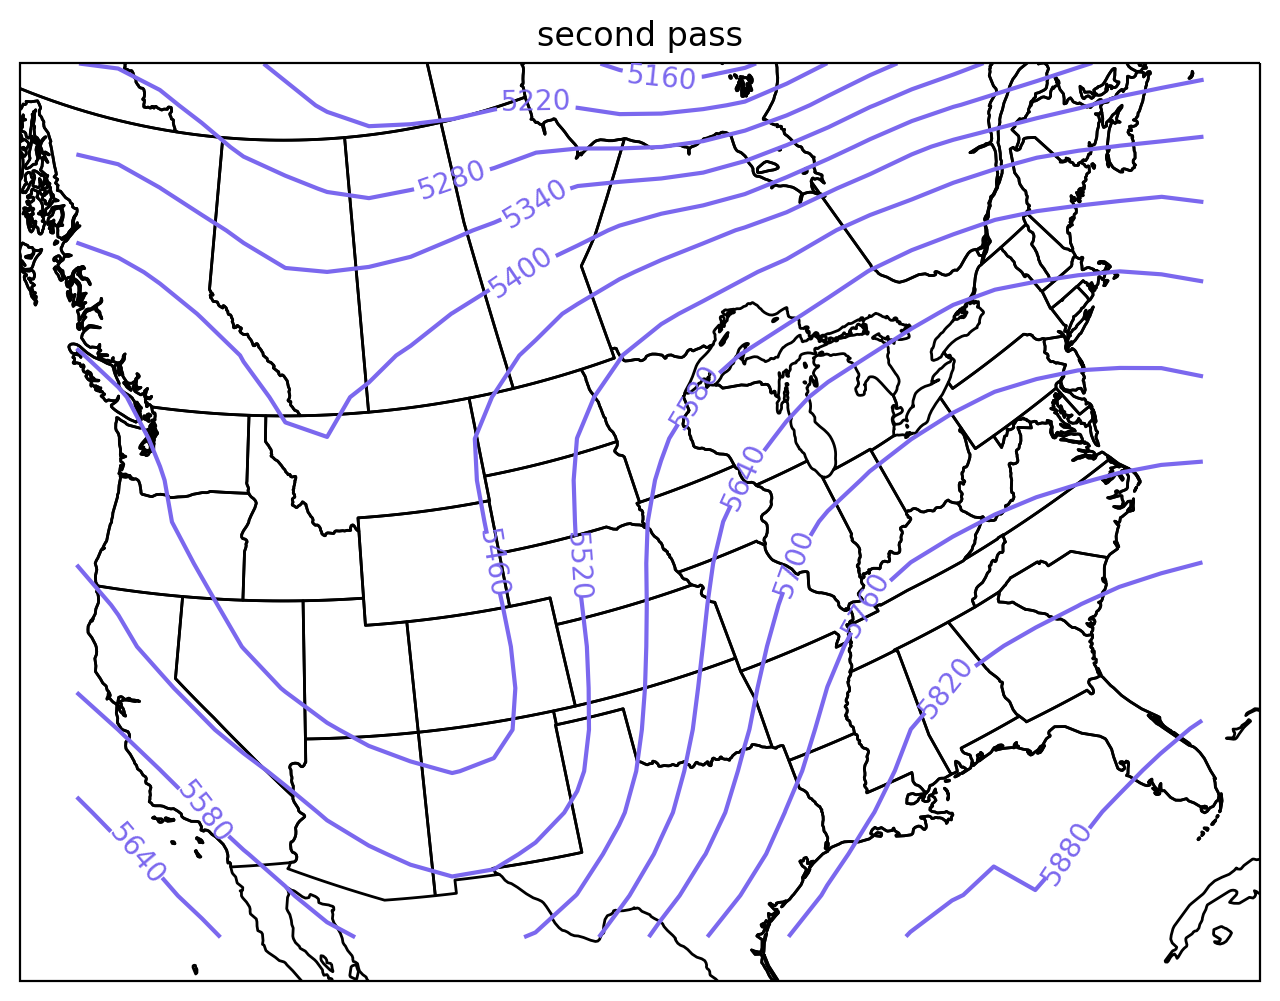

In [12]:
#second pass
for j in range(len(x)):
    for k in range(len(x[0])):
        xs=x[j,k]-xdev   #grid point - loc of obs
        ys=y[j,k]-ydev   #grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        #make sure obs are in roi
        roi_index=np.where(radius<=R2)[0]
        #empty matrix for weights
        weights=np.zeros(len(xdev))
        for i in roi_index:
            w=cressman(radius[i],R2)
            weights[i]=w
        analmat[j,k,1]=analmat[j,k,0]+(np.nansum(weights*(f0-P1))/np.nansum(weights))          
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,1],colors='mediumslateblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("second pass")
plt.savefig('secondpass.png')
#plt.show()

In [31]:
#third pass
#calculate relative x and y for bilinear
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P2=np.zeros(len(xdev))
#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear(ob_relx[i],ob_rely[i],1) #zero uses analysis value from second pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=R2)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                cress_a=cressman(radius[j,k],R2)
                weights_a[j,k]=cress_a
        p=np.sum(weights_a*analmat[:,:,1])/np.sum(weights_a)
    P2[i]=p

C:\Users\lynnl\AppData\Local\Temp\ipykernel_37240\375256171.py:21: RuntimeWarning: invalid value encountered in double_scalars
  p=np.sum(weights_a*analmat[:,:,1])/np.sum(weights_a)


C:\Users\lynnl\AppData\Local\Temp\ipykernel_37240\2876148501.py:13: RuntimeWarning: invalid value encountered in double_scalars
  analmat[j,k,2]=analmat[j,k,1]+(np.nansum(weights*(f0-P2))/np.nansum(weights))


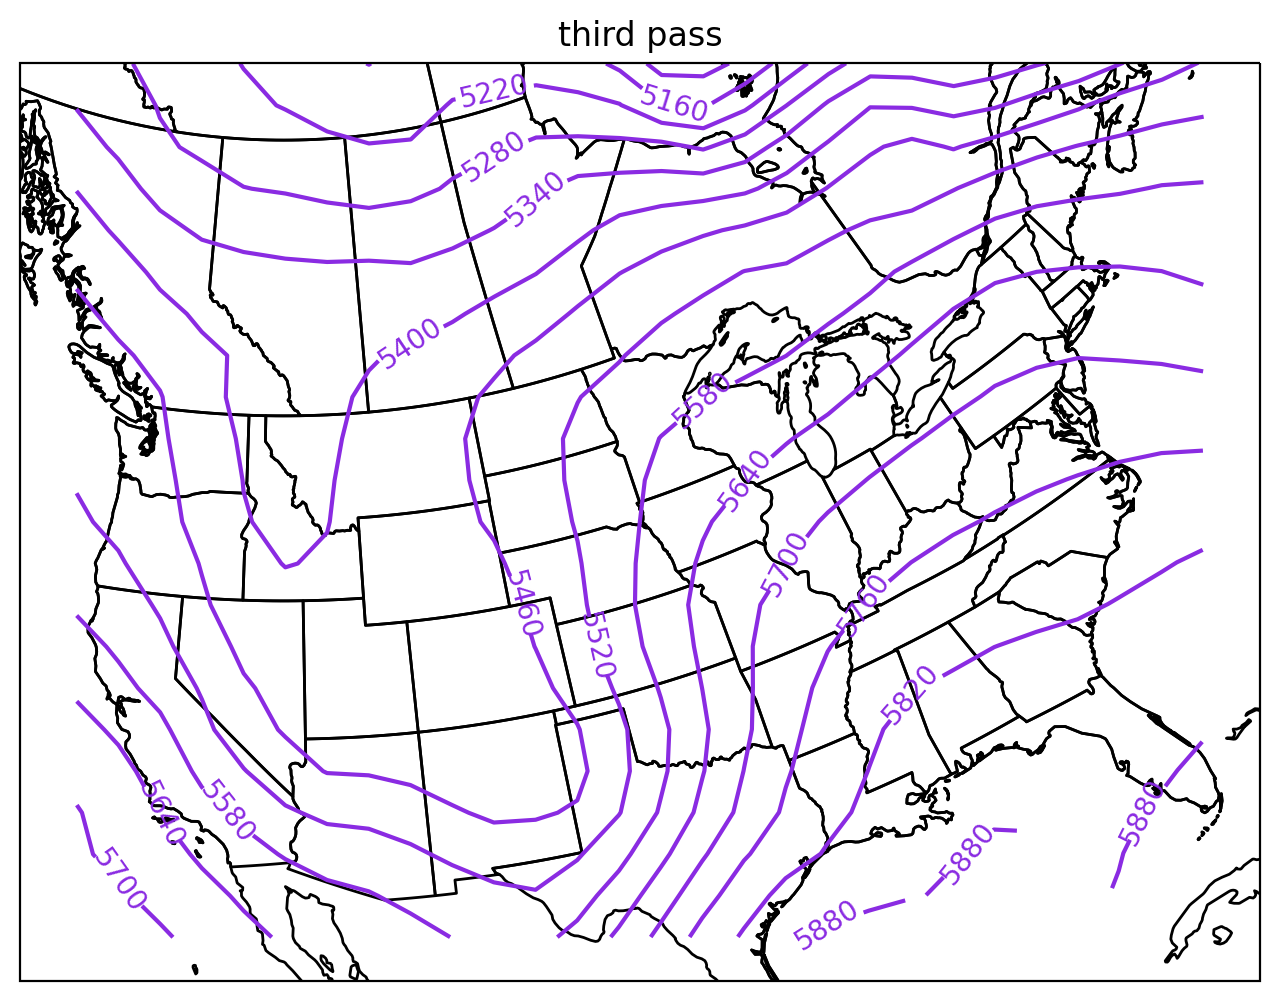

In [15]:
for j in range(len(x)):
    for k in range(len(x[0])):
        xs=x[j,k]-xdev   #grid point - loc of obs
        ys=y[j,k]-ydev   #grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        #make sure obs are in roi
        roi_index=np.where(radius<=R3)[0]
        #empty matrix for weights
        weights=np.zeros(len(xdev))
        for i in roi_index:
            w=cressman(radius[i],R3)
            weights[i]=w
        analmat[j,k,2]=analmat[j,k,1]+(np.nansum(weights*(f0-P2))/np.nansum(weights))
          
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,2],colors='blueviolet',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("third pass")
plt.savefig('thirdpass.png')
#plt.show()

In [16]:
### Calculate Analysis Differences
a2ma1=analmat[:,:,1]-analmat[:,:,0]
a3ma1=analmat[:,:,2]-analmat[:,:,0]
a3ma2=analmat[:,:,2]-analmat[:,:,1]

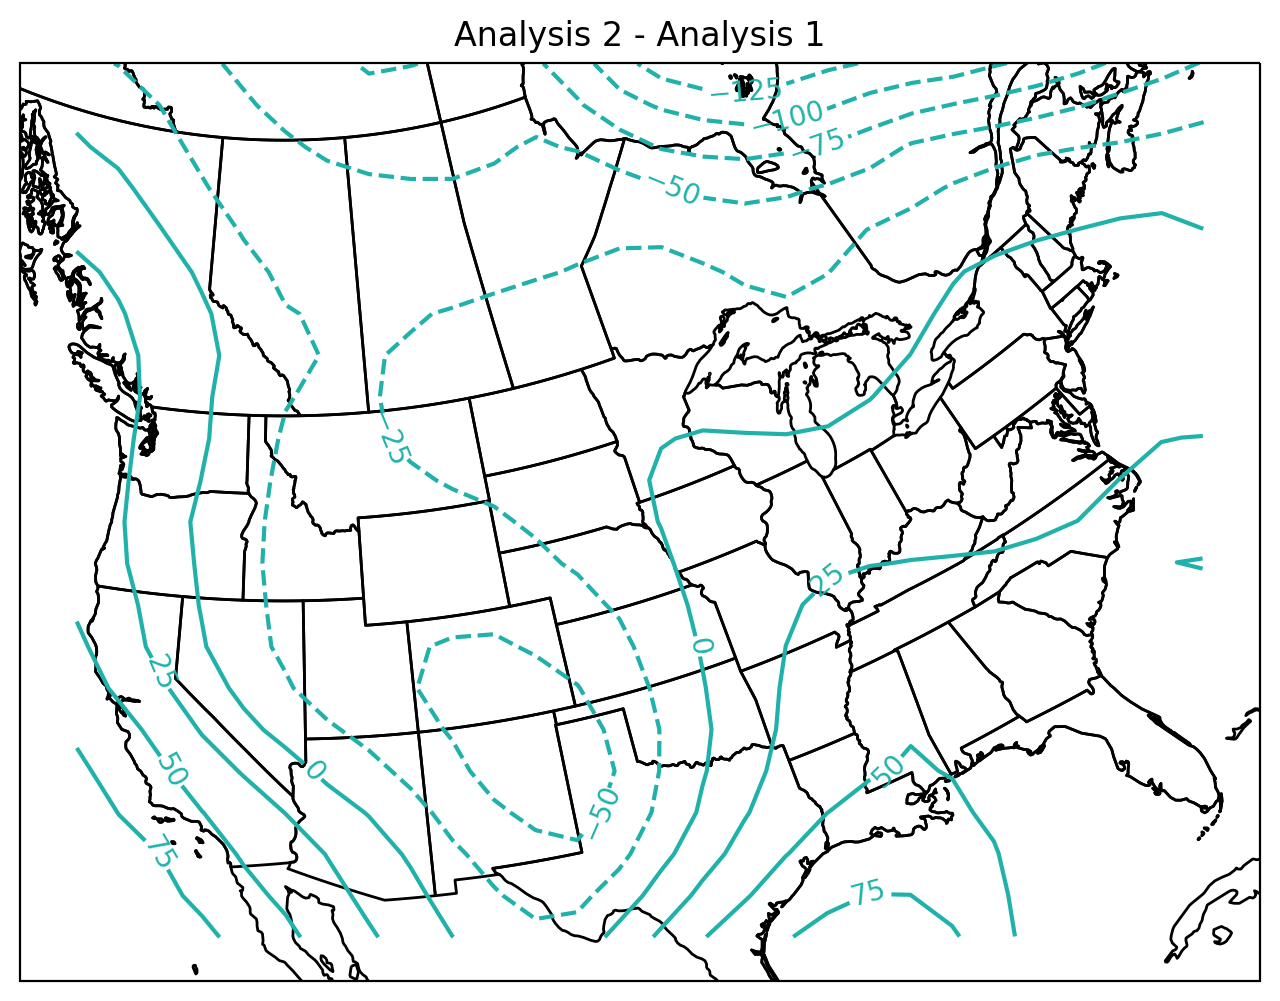

In [17]:
#differences
#2-1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,a2ma1,colors='lightseagreen',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("Analysis 2 - Analysis 1")
plt.savefig('1minus2.png')
#plt.show()


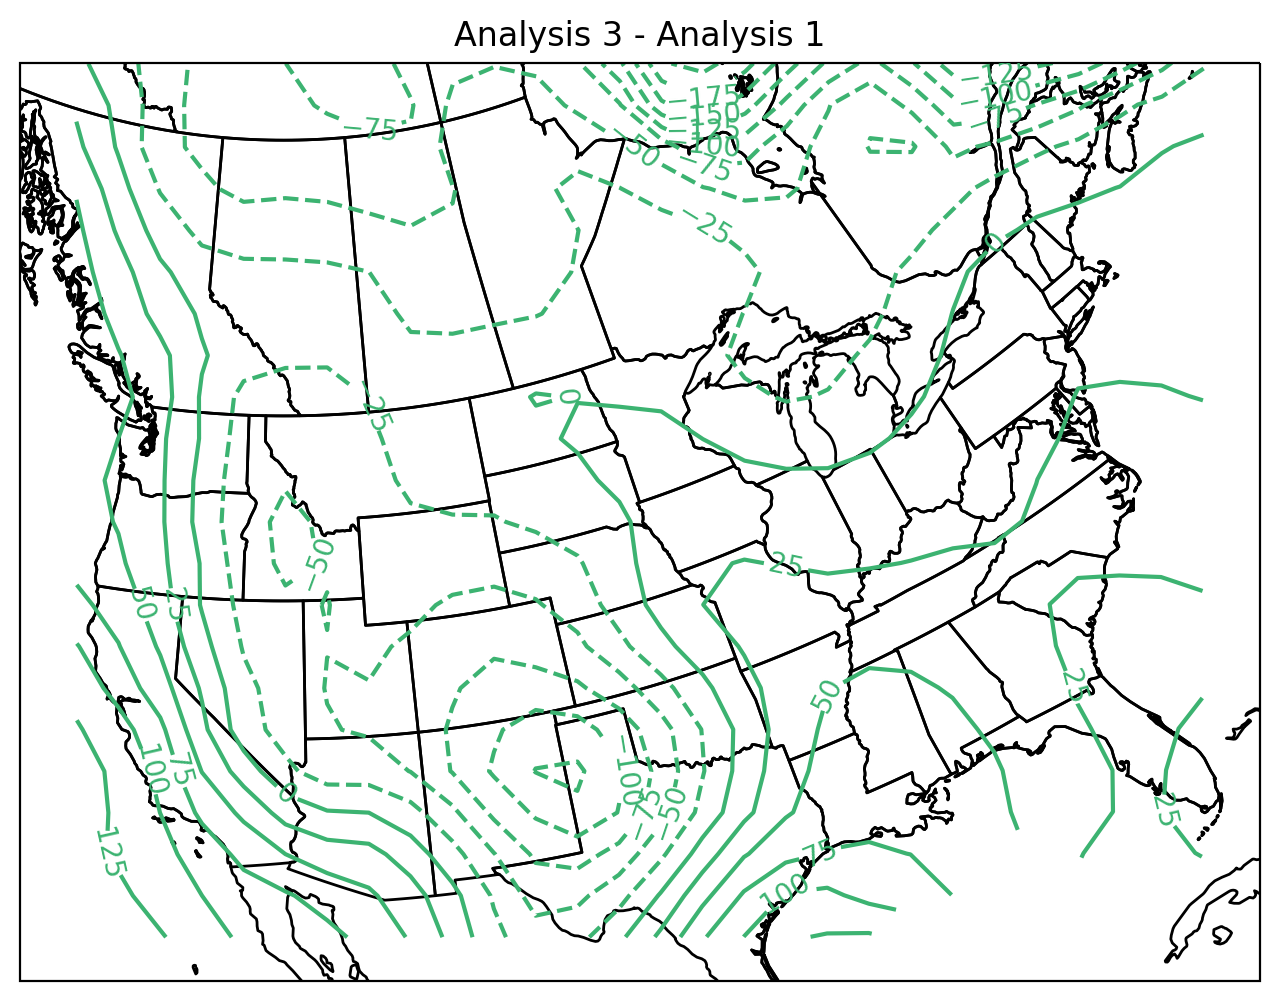

In [18]:
### Plot Analysis Differences ###
#3-1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,a3ma1,colors='mediumseagreen',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("Analysis 3 - Analysis 1")
plt.savefig('3minus1.png')
#plt.show()


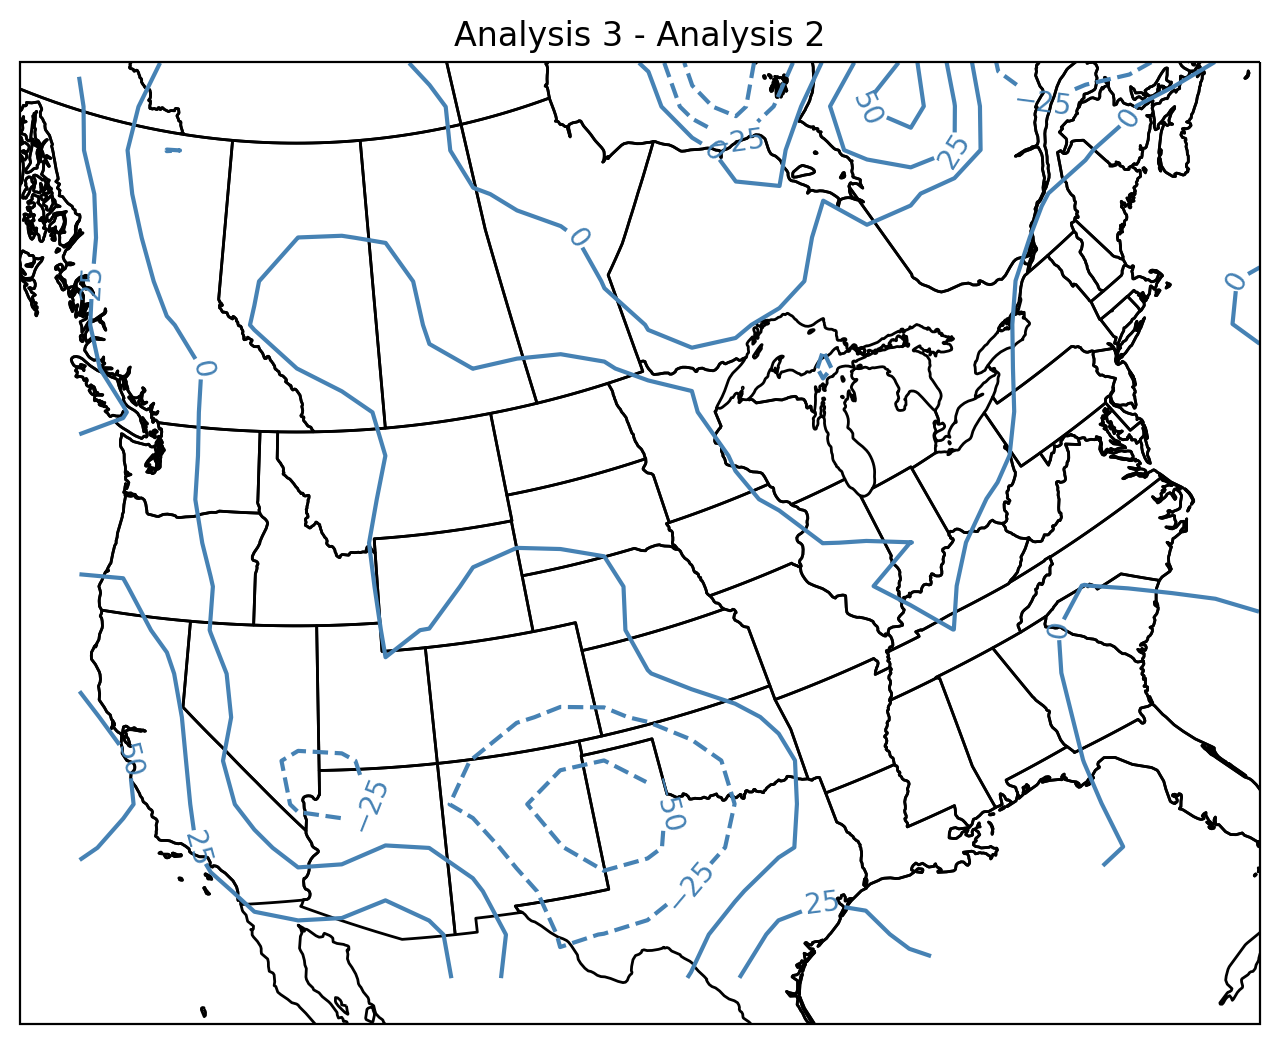

In [19]:
#differences
#3-2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,a3ma2,colors='steelblue',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("Analysis 3 - Analysis 2")
plt.savefig('3minus2.png')
#plt.show()

In [20]:
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P3=np.zeros(len(xdev))
#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear(ob_relx[i],ob_rely[i],2) #zero uses analysis value from second pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=R3)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                cress_a=cressman(radius[j,k],R3)
                weights_a[j,k]=cress_a
        p=np.sum(weights_a*analmat[:,:,2])/np.sum(weights_a)
    P3[i]=p

[5457.02610202 5540.09495548 5359.5017243  5322.50116199           nan
           nan           nan           nan           nan           nan
           nan 5451.9737703            nan 5370.20702578           nan
 5483.71041799 5229.54851147           nan           nan           nan
 5303.74135416 5249.95653642           nan 5452.93580895           nan
 5387.56310117 5451.88350323 5546.94591631           nan 5712.56799338
           nan 5445.79335778 5654.34237692 5483.56693323           nan
           nan 5616.479865   5789.87771674           nan 5504.0943411
 5821.57789361 5778.23764207 5395.64795518           nan           nan
 5668.14965703 5770.34693262 5502.94286832           nan 5636.46043095
 5814.73220959           nan 5512.91852194 5463.18948845 5680.09877745
 5556.38366898 5465.34677758 5676.63009788 5666.41303677 5664.827958
 5540.4267218  5889.55440023           nan 5820.41642723 5493.99433279
 5614.9992093  5674.83571982 5440.76932393 5419.81926636 5621.2821147
 5777.7085

In [21]:
#calculate rms values
#pass 1
diff1=(f0-P1)**2
diff1=diff1[~np.isnan(diff1)]
rms1=np.sqrt(np.sum(diff1)/len(diff1))
print(rms1)
#pass 2
diff2=(f0-P2)**2
diff2=diff2[~np.isnan(diff2)]
rms2=np.sqrt(np.sum(diff2)/len(diff2))
print(rms2)
#pass 3
diff3=(f0-P3)**2
diff3=diff3[~np.isnan(diff3)]
rms3=np.sqrt(np.sum(diff3)/len(diff3))
print(rms3)
#make rms array
rmsarray=[rms1,rms2,rms3]

74.54329800402628
35.12766126581706
11.681749880587574


In [95]:
### Store the analyses in text files ###
analysis_file_1=open("analysis_file1.txt","w+")
analysis1=str(analmat[:,:,0])
analysis_file_1.write(analysis1)
analysis_file_1.close()

analysis_file_2=open("analysis_file2.txt","w+")
analysis2=str(analmat[:,:,1])
analysis_file_2.write(analysis2)
analysis_file_2.close()

analysis_file_3=open("analysis_file3.txt","w+")
analysis3=str(analmat[:,:,2])
analysis_file_3.write(analysis3)
analysis_file_3.close()

In [96]:
### Store the difference fields in text files ###
diff_file_1=open("diff_file1.txt","w+")
dif1=str(a2ma1)
diff_file_1.write(dif1)
diff_file_1.close()

diff_file_2=open("diff_file2.txt","w+")
dif2=str(a3ma1)
diff_file_2.write(dif2)
diff_file_2.close()

diff_file_3=open("diff_file3.txt","w+")
dif3=str(a3ma2)
diff_file_3.write(dif3)
diff_file_3.close()

In [97]:
### Store RMS values in text file ###
rms_file=open("rms_file.txt","w+")
rmsf=str(rmsarray)
rms_file.write(rmsf)
rms_file.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

        There is a deep trough in Montana, Wyoming, Idaho, Colorado,Utah, New Mexico
        and Arizona. There is a ridge over the Eastern United States maximizing in Alabama,
        Georgia, Tennessee, Ohio, Indiana,and Michigan. The upper level flow for the
        United States is very meridional.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
        The third analysis shows more small scale details and generally has more contours
        than the first or second analysis. The second has more details than the first.
        The first analysis is the most smooth, followed by the second, and then the third.
        This occurs because the SCM resolves large scale features first, followed by smaller
        scale features on each pass. When only more large scale features are resolved, a 
        smoother map is created (first analysis) vs. The third analysis which has more 
        shortwave features, but is less smooth.

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
        As the number of successive correction passes increases, the analysis will converge
        to the observations at the observation locations. This is only desireable if the obs
        are perfect. It ultimately gives zero weight to the background, which in a case with
        perfect observations is fine, however obs are nearly never perfect, so it is usually 
        undesirable. With non-perfect obs the analysis will be incorrect if it converges to 
        the obs, because they are not exactly correct.
    

'''